In [1]:
import numpy as np
import os
import netCDF4
from scipy import stats
from scipy import io
from sstanalysis import gfd
from scipy import interpolate as naiso
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

In [3]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0]

In [4]:
roll = -1000
west, est, sud, nord = 154.9, 180., 30., 45.4
lonrange=np.array([west,est]) 
latrange=np.array([sud,nord])

base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)

SSH = np.roll(f.variables['SSH_2'][0], roll)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

# step 1: figure out the box indices
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_pc, imax_pc = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_pc, jmax_pc = jrange.min(), jrange.max()
print imin_pc, imax_pc, jmin_pc, jmax_pc

SSH_domain = SSH[..., jmin:jmax, imin:imax]
#U_domain = U[..., jmin:jmax, imin:imax]
jLs, jLe = (1300,1800)
iLs, iLe = (1500,2400)
print tlat[jLs,iLs], tlat[jLe,iLe], tlon[jLs,iLs], tlon[jLe,iLe]

plt.figure(figsize=(18,5))
#plt.subplot(121)
plt.imshow(SSH_domain, origin='bottom')
#plt.subplot(122)
plt.figure(figsize=(12,5))
plt.pcolormesh(tlon[jLs:jLe, iLs:iLe], tlat[jLs:jLe, iLs:iLe], SSH[..., jLs:jLe, iLs:iLe]*1e-2, cmap ='RdBu_r')
plt.title('Sea-surface Height',fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.clim([-1,1])
plt.axis('tight')
plt.colorbar()

#plt.figure(figsize=(10,10))
#plt.imshow(U_domain, origin='bottom')
print tlon[jLs:jLe, iLs:iLe].shape, tlat[jLs:jLe, iLs:iLe].shape, SSH[..., jLs:jLe, iLs:iLe].shape

1649 1899 1494 1667


NameError: name 'jmin' is not defined

In [32]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (12., 54.)
lon_start, lon_end = (140., 232.1)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
Lon = np.zeros((Degy+1,Degx+1))
Lat = np.zeros((Degy+1,Degx+1))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb = np.zeros((Degy,Degx))
psd_slopes_Aug = np.zeros((Degy,Degx))
psd_level_Feb = np.zeros((Degy,Degx))
psd_level_Aug = np.zeros((Degy,Degx))
L_1 = np.zeros((Degy,Degx)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon.shape

9 4
(5, 10)


# PSD #

In [38]:
j,i = (0,0)
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:
        if north <= lat_end:
            if east <= lon_end:
                # February
                NtFeb = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                        varname='SSH_2', roll=-1080, xmin=imin_pc, xmax=imax_pc, ymin=jmin_pc, ymax=jmax_pc, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                    if yearnum == 1:
                        N = len(Ki)
                        isospec_sum_Feb = np.zeros(N)
                    isospec_sum_Feb += isospec_Feb
                    #NtFeb += Nt_Feb

                isospec_ave_Feb = isospec_sum_Feb/yearnum
        
                # August
                NtAug = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                    varname='SSH_2', roll=-1080, xmin=imin_pc, xmax=imax_pc, ymin=jmin_pc, ymax=jmax_pc, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                    if yearnum == 1:
                        N = len(Ki)
                        isospec_sum_Aug = np.zeros(N)
                    isospec_sum_Aug += isospec_Aug
                    #NtAug += Nt_Aug

                isospec_ave_Aug = isospec_sum_Aug/yearnum
        
                Ns = 15
                Ne = N/5
                ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
                ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
        
        roll = -1080
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SSH = np.roll(f.variables['SSH_2'][0], roll)  # SST(time, lat, lon)
        #U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        SSH_domain = SSH[..., jmin:jmax, imin:imax]
        #U_domain = U[..., jmin:jmax, imin:imax]


        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb[j,i] = ps_slope_Feb
                    psd_slopes_Aug[j,i] = ps_slope_Aug
                    psd_level_Feb[j,i] = ps_fit_Feb[-1]
                    psd_level_Aug[j,i] = ps_fit_Aug[-1]
                    L_1[j,i] = Ki[Ne-1]
                    if north > lat_end-2*dlat and north <= lat_end-dlat:
                        plt.figure(figsize=(6,6))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                        plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                        plt.title('Isotropic PSD (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb[j,i] = np.nan
                    psd_slopes_Aug[j,i] = np.nan
                    psd_level_Feb[j,i] = np.nan
                    psd_level_Aug[j,i] = np.nan
                    L_1[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1
    
    
        

IndexError: index 86 is out of bounds for axis 0 with size 0

In [9]:
fname = 'psd_slope_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_slopes_Feb, 'Aug':psd_slopes_Aug, 'Lat':Lat, 'Lon':Lon})

fname = 'psd_level_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_level_Feb, 'Aug':psd_level_Aug, 'LenScale':(L_1*.5/np.pi)**-1*1e-3})

<matplotlib.colorbar.Colorbar instance at 0x7f9b400a14d0>

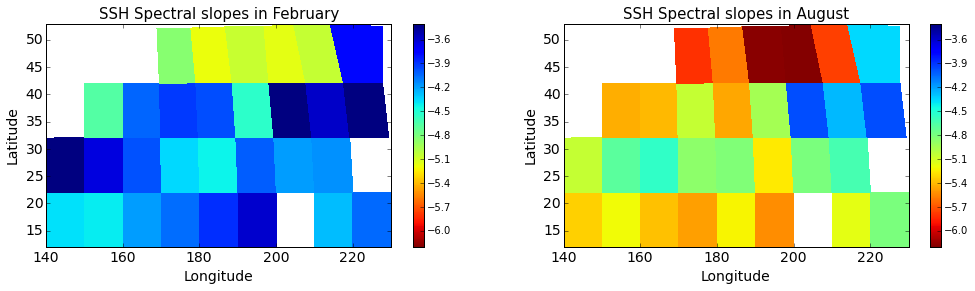

In [11]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb),cmap='jet_r')
plt.title('SSH Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug),cmap='jet_r')
plt.title('SSH Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

-5.67101529222 -3.65615534617


<matplotlib.colorbar.Colorbar instance at 0x7f62030eb050>

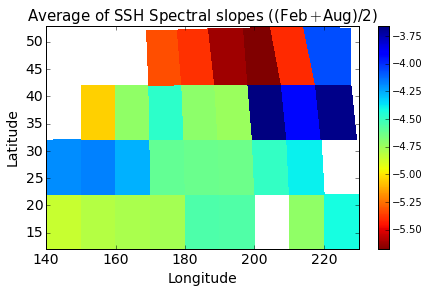

In [27]:
Ave = .5*(psd_slopes_Feb+psd_slopes_Aug)
print np.nanmin(Ave),np.nanmax(Ave)

plt.figure(figsize=(7,4))
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(Ave),cmap='jet_r')
plt.title('Average of SSH Spectral slopes ((Feb$+$Aug)/2)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([np.nanmin(Ave),np.nanmax(Ave)])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cfcd766c8>

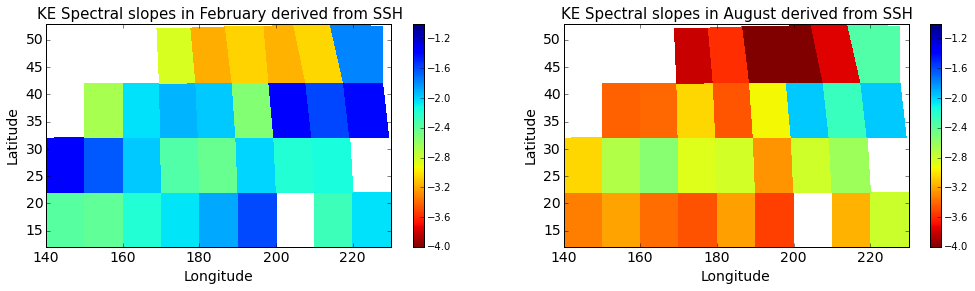

In [14]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb+2),cmap='jet_r')
plt.title('KE Spectral slopes in February derived from SSH', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-4,-1])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug+2),cmap='jet_r')
plt.title('KE Spectral slopes in August derived from SSH', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-4,-1])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

In [15]:
fname = 'psd_slope_Vel_Pacific.mat'
f_psd = io.loadmat(fname)

psd_slopes_Feb_KE = f_psd['Feb']
psd_slopes_Aug_KE = f_psd['Aug']

<matplotlib.colorbar.Colorbar instance at 0x7f1cfadefcb0>

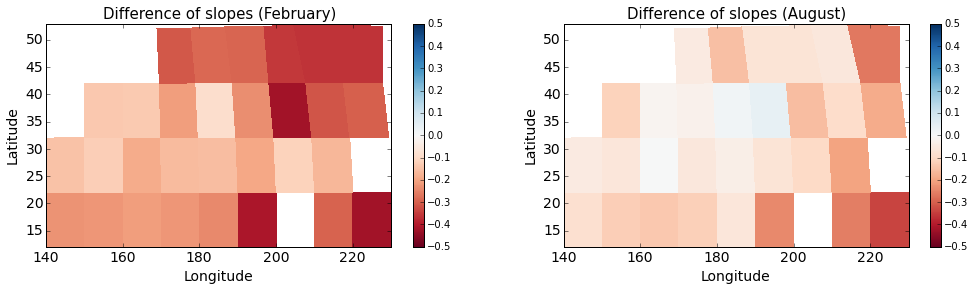

In [21]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb_KE-psd_slopes_Feb-2),cmap='RdBu')
plt.title('Difference of slopes (February)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.5,.5])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug_KE-psd_slopes_Aug-2),cmap='RdBu')
plt.title('Difference of slopes (August)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.5,.5])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cfa2bbef0>

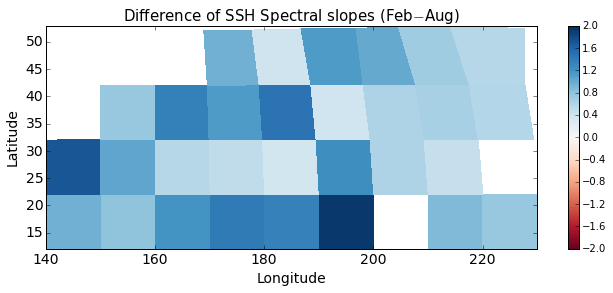

In [27]:
plt.figure(figsize=(11,4))
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug),cmap='RdBu')
plt.title('Difference of SSH Spectral slopes (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.,2.])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

# Structure Function #

sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.0143745).
  warn(errstr)
-c:3: RuntimeWarning: divide by zero encountered in log2
sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.0839354).
  warn(errstr)
sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.198223).
  warn(errstr)
sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.0175174).
  warn(errstr)


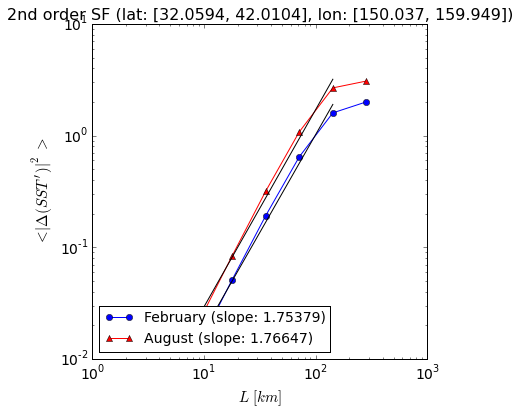

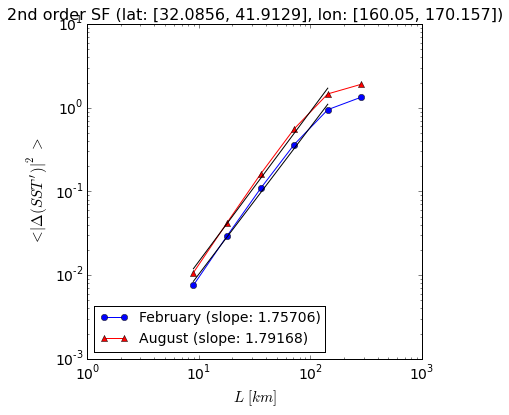

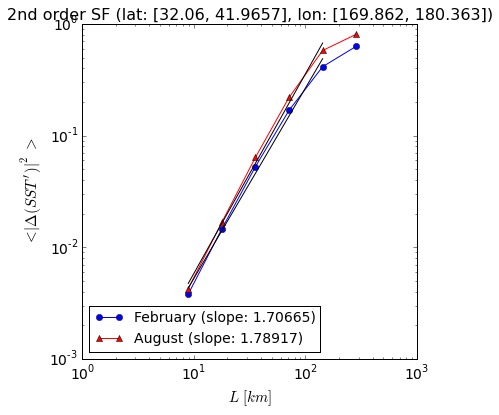

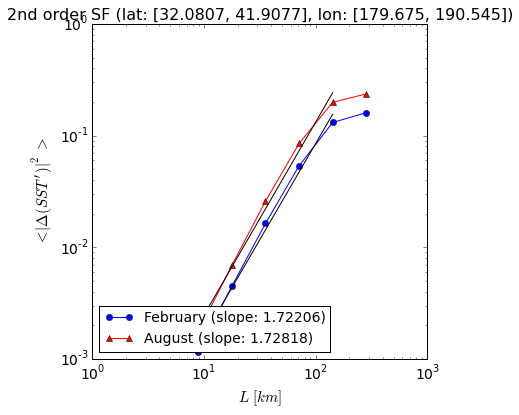

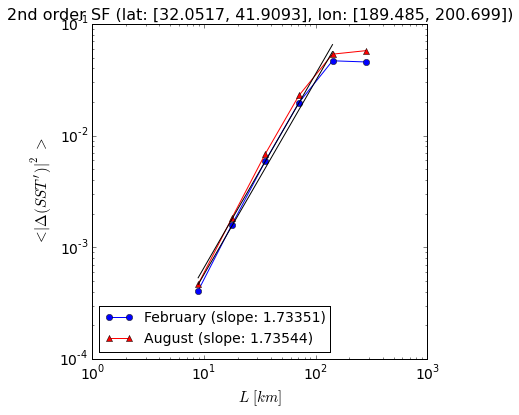

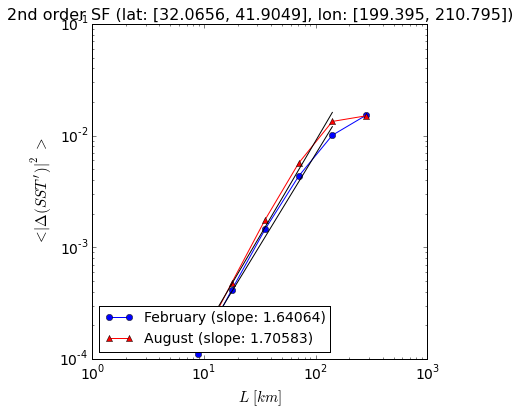

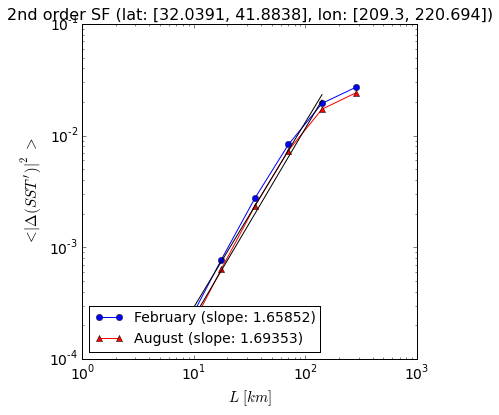

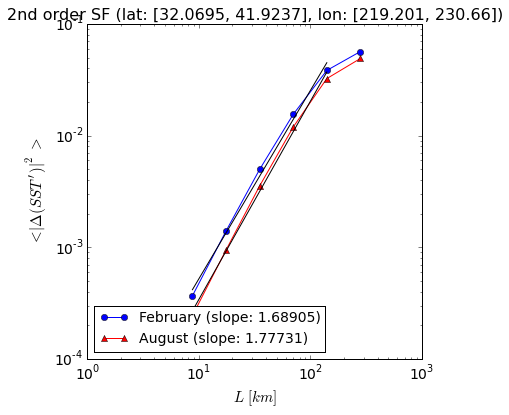

In [5]:
sf_slopes_Feb = np.zeros((Degy,Degx))
sf_slopes_Aug = np.zeros((Degy,Degx))
sf_level_Feb = np.zeros((Degy,Degx))
sf_level_Aug = np.zeros((Degy,Degx))
L_sf = np.zeros((Degy,Degx)) 

j,i = (0,0)
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:
        if north <= lat_end:
            if east <= lon_end:
                # February
                NtFeb = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Feb, dx, dy, L_Feb, SFi_Feb, SFj_Feb, lon, lat, land_frac, MAX_LAND = p.structure_function(
                                                                                                        varname='SSH_2', lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(L_Feb)
                        StrucFunc_sum_Febi = np.zeros(N)
                        StrucFunc_sum_Febj = np.zeros(N)
                    StrucFunc_sum_Febi += SFi_Feb
                    StrucFunc_sum_Febj += SFj_Feb
                    NtFeb += Nt_Feb

                StrucFunc_ave_Febi = StrucFunc_sum_Febi/NtFeb
                StrucFunc_ave_Febj = StrucFunc_sum_Febj/NtFeb
                StrucFunc_ave_Feb = .5*(StrucFunc_ave_Febi+StrucFunc_sum_Febj)
        
                # August
                NtAug = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Aug, dx, dy, L_Aug, SFi_Aug, SFj_Aug, lon, lat, land_frac, MAX_LAND = p.structure_function(
                                                                                                        varname='SSH_2', lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(L_Aug)
                        StrucFunc_sum_Augi = np.zeros(N)
                        StrucFunc_sum_Augj = np.zeros(N)
                    StrucFunc_sum_Augi += SFi_Aug
                    StrucFunc_sum_Augj += SFj_Aug
                    NtAug += Nt_Aug

                StrucFunc_ave_Augi = StrucFunc_sum_Augi/NtAug
                StrucFunc_ave_Augj = StrucFunc_sum_Augj/NtAug
                StrucFunc_ave_Aug = .5*(StrucFunc_ave_Augi+StrucFunc_sum_Augj)
        
                sf_fit_Feb, sf_slope_Feb = fit_loglog(L_Feb[:-1], StrucFunc_ave_Feb[:-1])
                sf_fit_Aug, sf_slope_Aug = fit_loglog(L_Aug[:-1], StrucFunc_ave_Aug[:-1])
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SSH = np.roll(f.variables['SSH_2'][0], roll)  # SST(time, lat, lon)
        #U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        #SST_domain = SST[..., jmin:jmax, imin:imax]
        #U_domain = U[..., jmin:jmax, imin:imax]

        #N = len(StrucFunc_ave_Feb)
        x = 2**np.arange(N)*dx*1e-3
        y = 2**np.arange(N)*dy*1e-3

        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    sf_slopes_Feb[j,i] = sf_slope_Feb
                    sf_slopes_Aug[j,i] = sf_slope_Aug
                    sf_level_Feb[j,i] = sf_fit_Feb[0]
                    sf_level_Aug[j,i] = sf_fit_Aug[0]
                    L_sf[j,i] = L_Feb[0]
                    if north > lat_end-2*dlat and north <= lat_end-dlat:
                    #if north <= lat_end:
                        plt.figure(figsize=(6,6))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        plt.loglog(x, StrucFunc_ave_Feb, 'bo-', label=r'February (slope: %g)' % sf_slope_Feb)
                        plt.loglog(x, StrucFunc_ave_Aug, 'r^-', label=r'August (slope: %g)' % sf_slope_Aug) 
                        plt.loglog(x[:-1], sf_fit_Feb, 'k')
                        plt.loglog(x[:-1], sf_fit_Aug, 'k')
                        plt.xlabel('$L \  [km]$', fontsize=15)
                        plt.ylabel('$< {| \Delta ({SST}^{\ \prime}) |}^2 >$', fontsize=15)
                        plt.title('2nd order SF (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    sf_slopes_Feb[j,i] = np.nan
                    sf_slopes_Aug[j,i] = np.nan
                    sf_level_Feb[j,i] = np.nan
                    sf_level_Aug[j,i] = np.nan
                    L_sf[j,i] = np.nan
            
                    #plt.figure(figsize=(15,6))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        

        west = east
        east = west+dlon
        i += 1
    south = north
    north = south+dlat
    j += 1

In [6]:
fname = 'sf_slope_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':sf_slopes_Feb, 'Aug':sf_slopes_Aug, 'Lat':Lat, 'Lon':Lon})

fname = 'sf_level_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':sf_level_Feb, 'Aug':sf_level_Aug, 'LenScale':L_sf})

In [4]:
fname = 'sf_slope_SSH_Pacific.mat'
f_sf = io.loadmat(fname)

print f_sf.keys()

fname = 'psd_slope_SSH_Pacific.mat'
f_psd = io.loadmat(fname)

print f_psd.keys()

psd_slopes_Feb = f_psd['Feb']
psd_slopes_Aug = f_psd['Aug']

sf_slopes_Feb = f_sf['Feb']
sf_slopes_Aug = f_sf['Aug']
Lon = f_sf['Lon']
Lat = f_sf['Lat']

['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__']
['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__']


<matplotlib.colorbar.Colorbar instance at 0x7f1cfca284d0>

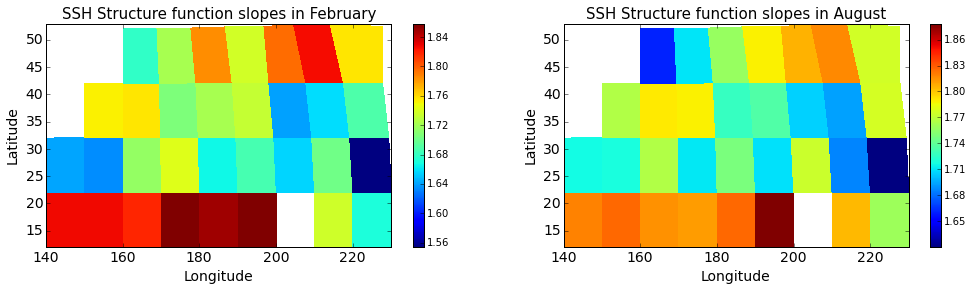

In [6]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(sf_slopes_Feb), cmap='jet')
plt.title('SSH Structure function slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([1,1.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(sf_slopes_Aug), cmap='jet')
plt.title('SSH Structure function slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([1,1.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cfcdf4638>

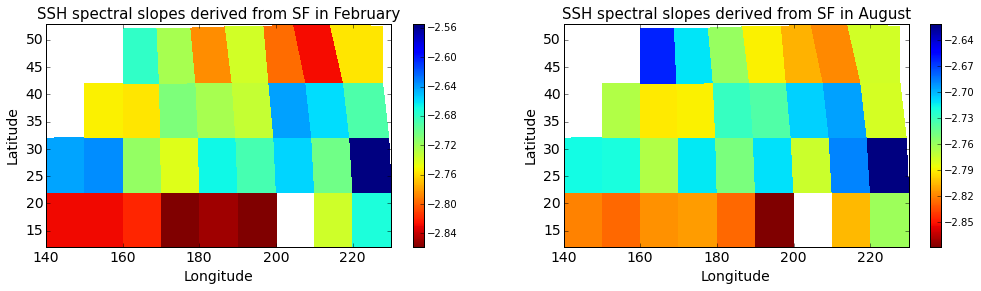

In [7]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-sf_slopes_Feb-1), cmap='jet_r')
plt.title('SSH spectral slopes derived from SF in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-sf_slopes_Aug-1), cmap='jet_r')
plt.title('SSH spectral slopes derived from SF in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cf9ae8cb0>

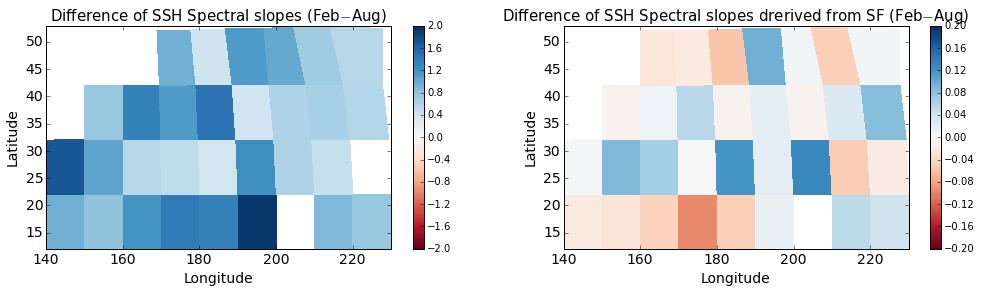

In [30]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug),cmap='RdBu')
plt.title('Difference of SSH Spectral slopes (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.,2.])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid((-sf_slopes_Feb-1)-(-sf_slopes_Aug-1)),cmap='RdBu')
plt.title('Difference of SSH Spectral slopes drerived from SF (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.2,.2])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

In [9]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb_global = np.zeros((Degy+1,Degx+1))
psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_Feb_global = np.zeros((Degy+1,Degx+1))
psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon_global.shape

34 11
(13, 36)


In [10]:
roll = -1080

fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc'
f = netCDF4.Dataset(fname)
mask = f.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)


lonrange=np.array([lon_start, lon_end])
latrange=np.array([lat_start, lat_end+5.])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()
#print imin, imax, jmin, jmax
#region_mask = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound, imin_bound:imax_bound]

In [11]:
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)
mask = f.variables['KMT'][:] <= 1
SSH_Feb = 1e-2*np.roll(np.ma.masked_array(f.variables['SSH_2'][0],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]  # SST(time, lat, lon)
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc'
f = netCDF4.Dataset(fname)
SSH_Aug = 1e-2*np.roll(np.ma.masked_array(f.variables['SSH_2'][0],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100] 
#U = np.roll(f.variables['U1_1'][0], roll)

In [15]:
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
#tlon = np.roll(f.variables['TLONG'][:], roll)
#tlat = np.roll(f.variables['TLAT'][:], roll)
mask_global = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]

In [9]:
Ny, Nx = tlon.shape
x = np.arange(0,Nx)
y = np.arange(0,Ny)
X,Y = np.meshgrid(x,y)
Zr = tlon.ravel()
Xr = np.ma.masked_array(X.ravel(), Zr.mask)
Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
Znew = Zr.data
Znew[Zr.mask] = Zm
Znew.shape = tlon.shape
tlon = Znew.copy()

Zr = tlat.ravel()
Xr = np.ma.masked_array(X.ravel(), Zr.mask)
Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
Znew = Zr.data
Znew[Zr.mask] = Zm
Znew.shape = tlat.shape
tlat = Znew.copy()

In [10]:
print tlon.shape, tlat.shape

(1578, 3523) (1578, 3523)


In [ ]:
from tempfile import TemporaryFile
interpLatnLon = TemporaryFile()
np.savez(interpLatnLon,tlat=tlat,tlon=tlon)
#np.savez('interpLat',tlat)
interpLatnLon.seek(0)

In [16]:
import numpy as np
npzfile = np.load('interpLatnLon.npz')
print npzfile.files
print npzfile['arr_0'].shape
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']

['arr_1', 'arr_0']
(1578, 3523)


<matplotlib.colorbar.Colorbar instance at 0x7f91b3af37a0>

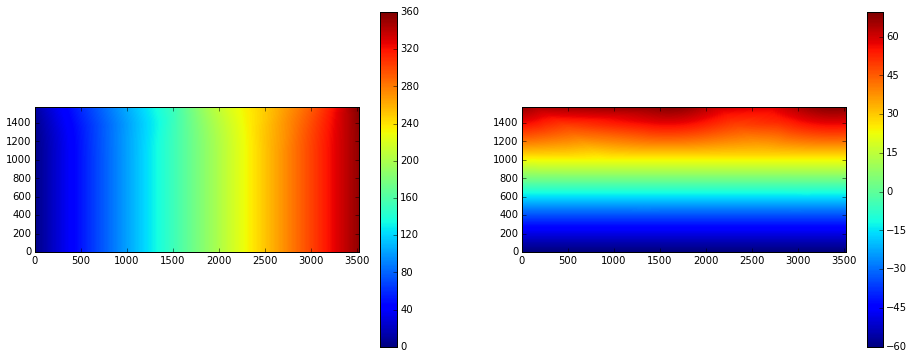

In [17]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(tlon, origin='bottom')
plt.colorbar()
plt.subplot(122)
plt.imshow(tlat, origin='bottom')
plt.colorbar()

In [ ]:
#roll = -1080
crit = 0.01
#fname_set = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
#f_set = netCDF4.Dataset(fname_set)
#mask = f_set.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f_set.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(np.ma.masked_array(f_set.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]
#tlat = np.roll(np.ma.masked_array(f_set.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]

#Ny, Nx = tlon.shape
#x = np.arange(0,Nx)
#y = np.arange(0,Ny)
#X,Y = np.meshgrid(x,y)
#Zr = tlon.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlon.shape
#tlon = Znew.copy()

#Zr = tlat.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlat.shape
#tlat = Znew.copy()

fname = 'psd_slope_SSH_Global.mat'
f_psd_slope = io.loadmat(fname)
Lon = f_psd_slope['Lon']
Lat = f_psd_slope['Lat']

j,i = (0,0)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)

while south < lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while west < lon_end+dlon:

        lonrange = np.array([west,east])
        latrange = np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax
        
        
        region_mask = mask_global[jmin:jmax, imin:imax]
        Ny, Nx = region_mask.shape
        land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
        SSH_domain_Feb = SSH_Feb[..., jmin:jmax, imin:imax]
        SSH_domain_Aug = SSH_Aug[..., jmin:jmax, imin:imax]

    
        if south < lat_end+dlat:
            if west < lon_end+dlon:
                if land_fraction<crit:
                    print 'Index range (i): ', imin, imax
                    print 'Index range (j): ', jmin, jmax
                    # February
                    NtFeb = 0.
                    # load data files
                    nday = 1
#                     for yearnum in np.arange(1,6):
#                         daynum = 0
#                         #for month in np.arange(1,13):
#                         fname = os.path.join(base_dir,
#                                  'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
#                                  % (nday, yearnum+45))
#                         #print fname
#                         p = popmodel.POPFile(fname)
#                         #T = p.nc.variables['SST'][:]
#                         Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
#                                                                                 varname='SSH_2', roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
#                         if yearnum == 1:
#                             N = len(Ki)
#                             isospec_sum_Feb = np.zeros(N)
#                         isospec_sum_Feb += isospec_Feb
#                         #NtFeb += Nt_Feb

#                     isospec_ave_Feb = isospec_sum_Feb/(yearnum*Nt_Feb)
                    #print isospec_ave_Feb
        
                    # August
                    NtAug = 0.
                    # load data files
                    nday = 1
#                     for yearnum in np.arange(1,6):
#                         daynum = 0
#                         #for month in np.arange(1,13):
#                         fname = os.path.join(base_dir, 
#                                  'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
#                                  % (nday, yearnum+45))
#                         #print fname
#                         p = popmodel.POPFile(fname)
#                         #T = p.nc.variables['SST'][:]
#                         Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
#                                                                                 varname='SSH_2', roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
#                         if yearnum == 1:
#                             N = len(Ki)
#                             isospec_sum_Aug = np.zeros(N)
#                         isospec_sum_Aug += isospec_Aug
#                         #NtAug += Nt_Aug

#                     isospec_ave_Aug = isospec_sum_Aug/(yearnum*Nt_Aug)
        
                    #Ns = 10
                    #Ne = N/4
#                     Le = 9e1
#                     Ls = 3e2
#                     N = 128
#                     if np.all(np.isnan(isospec_ave_Aug)) == False and np.all(np.isnan(isospec_ave_Feb)) == False:
#                         Ns = np.argmin(np.abs(2*np.pi/Ki*1e-3-Ls))
#                         Ne = np.argmin(np.abs(2*np.pi/Ki*1e-3-Le))
                        
#                     ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
#                     ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
#                     print 'PSD slopes (Feb): ', ps_slope_Feb
        
                    #U_domain = U[..., jmin:jmax, imin:imax]

                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
#                     psd_slopes_Feb_global[j,i] = ps_slope_Feb
#                     psd_slopes_Aug_global[j,i] = ps_slope_Aug
#                     psd_level_Feb_global[j,i] = ps_fit_Feb[-1]
#                     psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
#                     L_1_global[j,i] = Ki[-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                    if north < 65.:
                    #if north > 30. and north < 60.:
                        plt.figure(figsize=(4,7))
                        plt.subplot(211)
                        plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain_Feb - SSH_domain_Feb.mean(), cmap='RdBu_r')
                        plt.title('SSH (February)', fontsize=16)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                        plt.colorbar()
#                         plt.clim([SSH_domain_Feb.min(), - SSH_domain_Feb.min()])
                        plt.clim([-.5, .5])
                        plt.subplot(212)
                        plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain_Aug - SSH_domain_Aug.mean(), cmap='RdBu_r')
                        plt.title('SSH (August)', fontsize=16)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                        plt.colorbar()
#                         plt.clim([SSH_domain_Aug.min(), - SSH_domain_Aug.min()])
                        plt.clim([-.5, .5])
                        plt.show()
                        
                        print Lat[j,0], Lat[j+1,0], Lon[0,i], Lon[0,i+1]
#                         plt.figure(figsize=(6,5))
#                         plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
#                         plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
#                         plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
#                         plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
#                         plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
#                         plt.title('Isotropic PSD  (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
#                         plt.legend(loc='lower left', fontsize=14)
#                         plt.xticks(fontsize=14)
#                         plt.yticks(fontsize=14)
#                         plt.show()
                else:
                    print 'Too much land coverage to calculate spectra'
                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
#                     psd_slopes_Feb_global[j,i] = np.nan
#                     psd_slopes_Aug_global[j,i] = np.nan
#                     psd_level_Feb_global[j,i] = np.nan
#                     psd_level_Aug_global[j,i] = np.nan
#                     L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        if i>0:
            print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
        if j>0 and i==0:
            print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1
    
    
        

In [33]:
fname = 'psd_slope_SSH_Global.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_slopes_Feb_global, 'Aug':psd_slopes_Aug_global, 'Lat':Lat_global, 'Lon':Lon_global})

fname = 'psd_level_SSH_Global.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_level_Feb_global, 'Aug':psd_level_Aug_global, 'LenScale':(L_1_global*.5/np.pi)**-1*1e-3})

In [55]:
fname = 'psd_slope_SSH_Global.mat'
f_psd_slope = io.loadmat(fname)

fname = 'psd_level_SSH_Global.mat'
f_psd_level = io.loadmat(fname)

print f_psd_slope.keys(), f_psd_level.keys()

['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__'] ['Feb', 'LenScale', 'Aug', '__header__', '__globals__', '__version__']


In [56]:
psd_slopes_Feb = f_psd_slope['Feb']
psd_slopes_Aug = f_psd_slope['Aug']
Lon = f_psd_slope['Lon']
Lat = f_psd_slope['Lat']

<matplotlib.colorbar.Colorbar instance at 0x7f928a4bbb48>

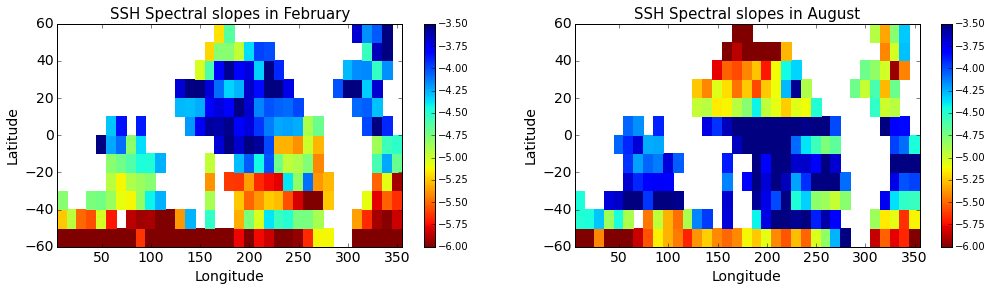

In [38]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb), cmap='jet_r')
plt.title('SSH Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-6,-3.5])
plt.axis('tight')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug), cmap='jet_r')
plt.title('SSH Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-6,-3.5])
plt.axis('tight')
plt.colorbar()

In [39]:
print np.nanmax(psd_slopes_Feb), np.nanmin(psd_slopes_Feb)
print np.nanmax(psd_slopes_Aug), np.nanmin(psd_slopes_Aug)

-2.48896927346 -7.20536920317
-2.62763514864 -6.39792145783


(5.0, 355.0, -60.0, 60.0)

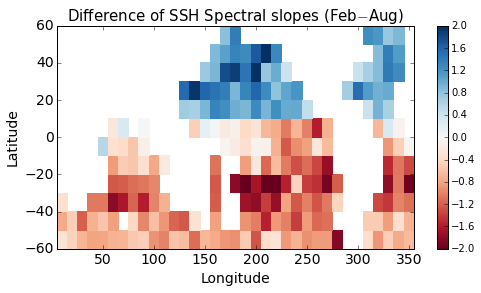

In [42]:
plt.figure(figsize=(8,4))
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug), cmap='RdBu')
plt.title('Difference of SSH Spectral slopes (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.,2.])
plt.colorbar()
plt.axis('tight')

In [20]:
from mpl_toolkits.basemap import Basemap

In [21]:
m = Basemap(projection='robin', lon_0=180)

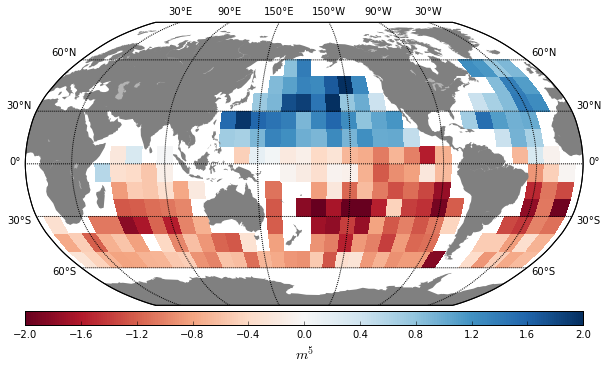

In [28]:
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug), cmap='RdBu')
pc.set_clim([-2.,2.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^5$', fontsize=14)

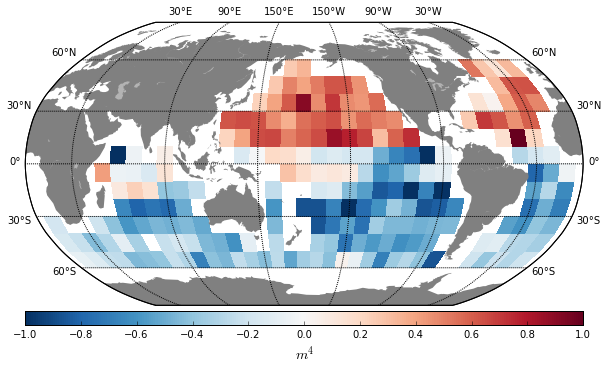

In [27]:
psd_levels_Feb = f_psd_level['Feb']
psd_levels_Aug = f_psd_level['Aug']

fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(psd_levels_Feb/psd_levels_Aug)), cmap='RdBu_r')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
#plt.title('Ratio of Power level')
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

In [116]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
#west, south = (lon_start, lat_start)
#east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_global_win = np.zeros((3,Degy+1,Degx+1))
#psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_global_win = np.zeros((3,Degy+1,Degx+1))
#psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon_global.shape

#roll = -1080
crit = 0.01
#fname_set = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
#f_set = netCDF4.Dataset(fname_set)
#mask = f_set.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f_set.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(np.ma.masked_array(f_set.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]
#tlat = np.roll(np.ma.masked_array(f_set.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]

#Ny, Nx = tlon.shape
#x = np.arange(0,Nx)
#y = np.arange(0,Ny)
#X,Y = np.meshgrid(x,y)
#Zr = tlon.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlon.shape
#tlon = Znew.copy()

#Zr = tlat.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlat.shape
#tlat = Znew.copy()


j,i = (0,0)

win = np.array([12,1,2])

for month in range(3):
    south = lat_start
    north = south+dlat
    j = 0
    print 'Month is: ', win[month]
    while south < lat_end+dlat:
        west = lon_start
        east = west+dlon
        i = 0
        while west < lon_end+dlon:

            lonrange = np.array([west,east])
            latrange = np.array([south,north])
            lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
            latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
            boxidx = lonmask & latmask # this won't necessarily be square
            irange = np.where(boxidx.sum(axis=0))[0]
            imin, imax = irange.min(), irange.max()
            jrange = np.where(boxidx.sum(axis=1))[0]
            jmin, jmax = jrange.min(), jrange.max()
            #print imin, imax, jmin, jmax
        
        
            region_mask = mask_global[jmin:jmax, imin:imax]
            Ny, Nx = region_mask.shape
            land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
            SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
            if south < lat_end+dlat:
                if west < lon_end+dlon:
                    if land_fraction<crit:

                        #print 'Index range (i): ', imin, imax
                        #print 'Index range (j): ', jmin, jmax
                        # February
                        Nt = 0.
                        # load data files
                        nday = 1
                        for yearnum in np.arange(1,6):
                            daynum = 0
                            #for month in np.arange(1,13):
                            fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-%02d-01.nc' 
                                 % (nday, yearnum+45, win[month]))
                            #print fname
                            p = popmodel.POPFile(fname)
                            #T = p.nc.variables['SST'][:]
                            Nt, Nx, Ny, k, l, spac2_ave, tilde2_ave, breve2_ave, Ki, isospec, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                varname='SSH_2', roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                            if yearnum == 1:
                                N = len(Ki)
                                isospec_sum = np.zeros(N)
                            isospec_sum += isospec
                            #NtFeb += Nt_Feb

                        isospec_ave = isospec_sum/yearnum
        
        
                        Ns = 15
                        Ne = N/4
                        ps_fit, ps_slope = fit_loglog(Ki[Ns:Ne], isospec_ave[Ns:Ne])
                        #ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
                        #print 'PSD slopes: ', ps_slope
        
                        #U_domain = U[..., jmin:jmax, imin:imax]

                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_win[month,j,i] = ps_slope
                        #psd_slopes_Aug_global[j,i] = ps_slope_Aug
                        psd_level_global_win[month,j,i] = ps_fit[-1]
                        #psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
                        if month==0:
                            L_1_global[j,i] = Ki[Ne-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                        #if north > -5. and north < 15.:
                            #plt.figure(figsize=(14,4))
                            #plt.subplot(121)
                            #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain)
                            #plt.title('SSH (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.subplot(122)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                            #plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                            #plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                            #plt.legend(loc='lower left', fontsize=14)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.show()
                    else:
                        #print 'Too much land coverage to calculate spectra'
                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_win[month,j,i] = np.nan
                        #psd_slopes_Aug_global[j,i] = np.nan
                        psd_level_global_win[month,j,i] = np.nan
                        #psd_level_Aug_global[j,i] = np.nan
                        if month==0:
                            L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        #if i>0:
            #print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
        #if j>0 and i==0:
            #print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
            west = east
            east = west+dlon
            i += 1
    
        south = north
        north = south+dlat
        j += 1
    
    
        

34 11
(13, 36)
Month is:  12
Month is:  1
Month is:  2


In [117]:
#from tempfile import TemporaryFile
#SSH_winter = TemporaryFile()
#np.savez(SSH_winter, slopes=psd_slopes_global_win, Plevel=psd_level_global_win, spacscale=L_1_global)
#np.savez('interpLat',tlat)
#SSH_winter.seek(0)

fname = 'SSH_winter.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'slopes':psd_slopes_global_win, 'Plevel':psd_slopes_global_win, 'SpacScale':L_1_global})

In [118]:
#npzfile = np.load('SSH_winter.npz')
#print npzfile.files
f_psd_win = io.loadmat(fname)

print f_psd_win.keys()

['SpacScale', '__header__', '__globals__', 'Plevel', 'slopes', '__version__']


In [119]:
Slopes_DJF = f_psd_win['slopes']

print Slopes_DJF.shape

(3, 12, 35)


In [120]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
#west, south = (lon_start, lat_start)
#east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_global_spr = np.zeros((3,Degy+1,Degx+1))
#psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_global_spr = np.zeros((3,Degy+1,Degx+1))
#psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon_global.shape

#roll = -1080
crit = 0.01
#fname_set = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
#f_set = netCDF4.Dataset(fname_set)
#mask = f_set.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f_set.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(np.ma.masked_array(f_set.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]
#tlat = np.roll(np.ma.masked_array(f_set.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]

#Ny, Nx = tlon.shape
#x = np.arange(0,Nx)
#y = np.arange(0,Ny)
#X,Y = np.meshgrid(x,y)
#Zr = tlon.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlon.shape
#tlon = Znew.copy()

#Zr = tlat.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlat.shape
#tlat = Znew.copy()


j,i = (0,0)

spr = np.array([3,4,5])

for month in range(3):
    south = lat_start
    north = south+dlat
    j = 0
    print 'Month is: ', spr[month]
    while south < lat_end+dlat:
        west = lon_start
        east = west+dlon
        i = 0
        while west < lon_end+dlon:

            lonrange = np.array([west,east])
            latrange = np.array([south,north])
            lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
            latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
            boxidx = lonmask & latmask # this won't necessarily be square
            irange = np.where(boxidx.sum(axis=0))[0]
            imin, imax = irange.min(), irange.max()
            jrange = np.where(boxidx.sum(axis=1))[0]
            jmin, jmax = jrange.min(), jrange.max()
            #print imin, imax, jmin, jmax
        
        
            region_mask = mask_global[jmin:jmax, imin:imax]
            Ny, Nx = region_mask.shape
            land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
            SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
            if south < lat_end+dlat:
                if west < lon_end+dlon:
                    if land_fraction<crit:

                        #print 'Index range (i): ', imin, imax
                        #print 'Index range (j): ', jmin, jmax
                        # February
                        Nt = 0.
                        # load data files
                        nday = 1
                        for yearnum in np.arange(1,6):
                            daynum = 0
                            #for month in np.arange(1,13):
                            fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-%02d-01.nc' 
                                 % (nday, yearnum+45, spr[month]))
                            #print fname
                            p = popmodel.POPFile(fname)
                            #T = p.nc.variables['SST'][:]
                            Nt, Nx, Ny, k, l, spac2_ave, tilde2_ave, breve2_ave, Ki, isospec, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                varname='SSH_2', roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                            if yearnum == 1:
                                N = len(Ki)
                                isospec_sum = np.zeros(N)
                            isospec_sum += isospec
                            #NtFeb += Nt_Feb

                        isospec_ave = isospec_sum/yearnum
        
        
                        Ns = 15
                        Ne = N/4
                        ps_fit, ps_slope = fit_loglog(Ki[Ns:Ne], isospec_ave[Ns:Ne])
                        #ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
                        print 'PSD slopes: ', ps_slope
        
                        #U_domain = U[..., jmin:jmax, imin:imax]

                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_spr[month,j,i] = ps_slope
                        #psd_slopes_Aug_global[j,i] = ps_slope_Aug
                        psd_level_global_spr[month,j,i] = ps_fit[-1]
                        #psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
                        if month==0:
                            L_1_global[j,i] = Ki[Ne-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                        #if north > -5. and north < 15.:
                            #plt.figure(figsize=(14,4))
                            #plt.subplot(121)
                            #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain)
                            #plt.title('SSH (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.subplot(122)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                            #plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                            #plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                            #plt.legend(loc='lower left', fontsize=14)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.show()
                    else:
                        #print 'Too much land coverage to calculate spectra'
                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_spr[month,j,i] = np.nan
                        #psd_slopes_Aug_global[j,i] = np.nan
                        psd_level_global_spr[month,j,i] = np.nan
                        #psd_level_Aug_global[j,i] = np.nan
                        if month==0:
                            L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        #if i>0:
            #print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
        #if j>0 and i==0:
            #print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
            west = east
            east = west+dlon
            i += 1
    
        south = north
        north = south+dlat
        j += 1
    
    
        

34 11
(13, 36)
Month is:  3
PSD slopes:  -6.9866462483
PSD slopes:  -7.78819430368
PSD slopes:  -6.8539726863
PSD slopes:  -7.0856449703
PSD slopes:  -7.40922425598
PSD slopes:  -7.07113826588
PSD slopes:  -6.37670557056
PSD slopes:  -6.35306210279
PSD slopes:  -5.97365334924
PSD slopes:  -6.62224037822
PSD slopes:  -6.72564513117
PSD slopes:  -6.3459908804
PSD slopes:  -6.19758212045
PSD slopes:  -6.24511857744
PSD slopes:  -6.03257797382
PSD slopes:  -6.50672595436
PSD slopes:  -6.5795025227
PSD slopes:  -5.95799758095
PSD slopes:  -5.81081508345
PSD slopes:  -6.30689315497
PSD slopes:  -5.76008786676
PSD slopes:  -6.09458873993
PSD slopes:  -6.19048946343
PSD slopes:  -6.3951344578
PSD slopes:  -6.15354060749
PSD slopes:  -5.76980275534
PSD slopes:  -5.43195469299
PSD slopes:  -4.87213308602
PSD slopes:  -6.71684261041
PSD slopes:  -6.73246307329
PSD slopes:  -6.82813302496
PSD slopes:  -6.63792388917
PSD slopes:  -7.21677205296
PSD slopes:  -5.38141399969
PSD slopes:  -4.9428832007

In [121]:
#from tempfile import TemporaryFile
#SSH_winter = TemporaryFile()
#np.savez(SSH_winter, slopes=psd_slopes_global_win, Plevel=psd_level_global_win, spacscale=L_1_global)
#np.savez('interpLat',tlat)
#SSH_winter.seek(0)

fname = 'SSH_spring.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'slopes':psd_slopes_global_spr, 'Plevel':psd_slopes_global_spr, 'SpacScale':L_1_global})

In [122]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
#west, south = (lon_start, lat_start)
#east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_global_sumr = np.zeros((3,Degy+1,Degx+1))
#psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_global_sumr = np.zeros((3,Degy+1,Degx+1))
#psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon_global.shape

#roll = -1080
crit = 0.01
#fname_set = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
#f_set = netCDF4.Dataset(fname_set)
#mask = f_set.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f_set.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(np.ma.masked_array(f_set.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]
#tlat = np.roll(np.ma.masked_array(f_set.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]

#Ny, Nx = tlon.shape
#x = np.arange(0,Nx)
#y = np.arange(0,Ny)
#X,Y = np.meshgrid(x,y)
#Zr = tlon.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlon.shape
#tlon = Znew.copy()

#Zr = tlat.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlat.shape
#tlat = Znew.copy()


j,i = (0,0)
sumr = np.array([6,7,8])

for month in range(3):
    south = lat_start
    north = south+dlat
    j = 0
    print 'Month is: ', sumr[month]
    while south < lat_end+dlat:
        west = lon_start
        east = west+dlon
        i = 0
        while west < lon_end+dlon:

            lonrange = np.array([west,east])
            latrange = np.array([south,north])
            lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
            latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
            boxidx = lonmask & latmask # this won't necessarily be square
            irange = np.where(boxidx.sum(axis=0))[0]
            imin, imax = irange.min(), irange.max()
            jrange = np.where(boxidx.sum(axis=1))[0]
            jmin, jmax = jrange.min(), jrange.max()
            #print imin, imax, jmin, jmax
        
        
            region_mask = mask_global[jmin:jmax, imin:imax]
            Ny, Nx = region_mask.shape
            land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
            #SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
            if south < lat_end+dlat:
                if west < lon_end+dlon:
                    if land_fraction<crit:

                        #print 'Index range (i): ', imin, imax
                        #print 'Index range (j): ', jmin, jmax
                        # February
                        Nt = 0.
                        # load data files
                        nday = 1
                        for yearnum in np.arange(1,6):
                            daynum = 0
                            #for month in np.arange(1,13):
                            fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-%02d-01.nc' 
                                 % (nday, yearnum+45, sumr[month]))
                            #print fname
                            p = popmodel.POPFile(fname)
                            #T = p.nc.variables['SST'][:]
                            Nt, Nx, Ny, k, l, spac2_ave, tilde2_ave, breve2_ave, Ki, isospec, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                varname='SSH_2', roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                            if yearnum == 1:
                                N = len(Ki)
                                isospec_sum = np.zeros(N)
                            isospec_sum += isospec
                            #NtFeb += Nt_Feb

                        isospec_ave = isospec_sum/yearnum
        
        
                        Ns = 15
                        Ne = N/4
                        ps_fit, ps_slope = fit_loglog(Ki[Ns:Ne], isospec_ave[Ns:Ne])
                        #ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
                        print 'PSD slopes: ', ps_slope
        
                        #U_domain = U[..., jmin:jmax, imin:imax]

                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_sumr[month,j,i] = ps_slope
                        #psd_slopes_Aug_global[j,i] = ps_slope_Aug
                        psd_level_global_sumr[month,j,i] = ps_fit[-1]
                        #psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
                        if month==0:
                            L_1_global[j,i] = Ki[Ne-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                        #if north > -5. and north < 15.:
                            #plt.figure(figsize=(14,4))
                            #plt.subplot(121)
                            #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain)
                            #plt.title('SSH (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.subplot(122)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                            #plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                            #plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                            #plt.legend(loc='lower left', fontsize=14)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.show()
                    else:
                        #print 'Too much land coverage to calculate spectra'
                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_sumr[month,j,i] = np.nan
                        #psd_slopes_Aug_global[j,i] = np.nan
                        psd_level_global_sumr[month,j,i] = np.nan
                        #psd_level_Aug_global[j,i] = np.nan
                        if month==0:
                            L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        #if i>0:
            #print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
        #if j>0 and i==0:
            #print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
            west = east
            east = west+dlon
            i += 1
    
        south = north
        north = south+dlat
        j += 1
    
    
        

34 11
(13, 36)
Month is:  6
PSD slopes:  -7.03573403604
PSD slopes:  -7.67715121844
PSD slopes:  -6.31964185379
PSD slopes:  -6.83437509803
PSD slopes:  -6.43568501711
PSD slopes:  -6.21099059373
PSD slopes:  -6.13308890302
PSD slopes:  -5.97463385217
PSD slopes:  -5.53562995366
PSD slopes:  -5.73533632815
PSD slopes:  -5.78710632112
PSD slopes:  -5.42958960875
PSD slopes:  -5.48991166148
PSD slopes:  -5.25307251317
PSD slopes:  -5.89179282391
PSD slopes:  -5.96063514984
PSD slopes:  -5.78786583939
PSD slopes:  -5.21426047226
PSD slopes:  -4.95249593858
PSD slopes:  -4.56042422966
PSD slopes:  -5.82164878838
PSD slopes:  -5.9107069137
PSD slopes:  -5.54693324321
PSD slopes:  -5.60097312222
PSD slopes:  -5.40086169277
PSD slopes:  -4.83990597848
PSD slopes:  -4.35388227028
PSD slopes:  -3.63633508142
PSD slopes:  -6.15115062239
PSD slopes:  -6.09245324579
PSD slopes:  -5.95477042143
PSD slopes:  -6.38154703318
PSD slopes:  -6.33400722673
PSD slopes:  -4.6018312839
PSD slopes:  -5.077999

In [123]:
#from tempfile import TemporaryFile
#SSH_winter = TemporaryFile()
#np.savez(SSH_winter, slopes=psd_slopes_global_win, Plevel=psd_level_global_win, spacscale=L_1_global)
#np.savez('interpLat',tlat)
#SSH_winter.seek(0)

fname = 'SSH_summer.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'slopes':psd_slopes_global_sumr, 'Plevel':psd_slopes_global_sumr, 'SpacScale':L_1_global})

In [124]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
#west, south = (lon_start, lat_start)
#east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_global_aut = np.zeros((3,Degy+1,Degx+1))
#psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_global_aut = np.zeros((3,Degy+1,Degx+1))
#psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon_global.shape

#roll = -1080
crit = 0.01
#fname_set = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
#f_set = netCDF4.Dataset(fname_set)
#mask = f_set.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f_set.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(np.ma.masked_array(f_set.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]
#tlat = np.roll(np.ma.masked_array(f_set.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]

#Ny, Nx = tlon.shape
#x = np.arange(0,Nx)
#y = np.arange(0,Ny)
#X,Y = np.meshgrid(x,y)
#Zr = tlon.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlon.shape
#tlon = Znew.copy()

#Zr = tlat.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlat.shape
#tlat = Znew.copy()


j,i = (0,0)
aut = np.array([9,10,11])

for month in range(3):
    south = lat_start
    north = south+dlat
    j = 0
    print 'Month is: ', aut[month]
    while south < lat_end+dlat:
        west = lon_start
        east = west+dlon
        i = 0
        while west < lon_end+dlon:

            lonrange = np.array([west,east])
            latrange = np.array([south,north])
            lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
            latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
            boxidx = lonmask & latmask # this won't necessarily be square
            irange = np.where(boxidx.sum(axis=0))[0]
            imin, imax = irange.min(), irange.max()
            jrange = np.where(boxidx.sum(axis=1))[0]
            jmin, jmax = jrange.min(), jrange.max()
            #print imin, imax, jmin, jmax
        
        
            region_mask = mask_global[jmin:jmax, imin:imax]
            Ny, Nx = region_mask.shape
            land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
            #SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
            if south < lat_end+dlat:
                if west < lon_end+dlon:
                    if land_fraction<crit:

                        #print 'Index range (i): ', imin, imax
                        #print 'Index range (j): ', jmin, jmax
                        # February
                        Nt = 0.
                        # load data files
                        nday = 1
                        for yearnum in np.arange(1,6):
                            daynum = 0
                            #for month in np.arange(1,13):
                            fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-%02d-01.nc' 
                                 % (nday, yearnum+45, aut[month]))
                            #print fname
                            p = popmodel.POPFile(fname)
                            #T = p.nc.variables['SST'][:]
                            Nt, Nx, Ny, k, l, spac2_ave, tilde2_ave, breve2_ave, Ki, isospec, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                varname='SSH_2', roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                            if yearnum == 1:
                                N = len(Ki)
                                isospec_sum = np.zeros(N)
                            isospec_sum += isospec
                            #NtFeb += Nt_Feb

                        isospec_ave = isospec_sum/yearnum
        
        
                        Ns = 15
                        Ne = N/4
                        ps_fit, ps_slope = fit_loglog(Ki[Ns:Ne], isospec_ave[Ns:Ne])
                        #ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
                        print 'PSD slopes: ', ps_slope
        
                        #U_domain = U[..., jmin:jmax, imin:imax]

                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_aut[month,j,i] = ps_slope
                        #psd_slopes_Aug_global[j,i] = ps_slope_Aug
                        psd_level_global_aut[month,j,i] = ps_fit[-1]
                        #psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
                        if month==0:
                            L_1_global[j,i] = Ki[Ne-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                        #if north > -5. and north < 15.:
                            #plt.figure(figsize=(14,4))
                            #plt.subplot(121)
                            #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain)
                            #plt.title('SSH (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.subplot(122)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                            #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                            #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                            #plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                            #plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                            #plt.legend(loc='lower left', fontsize=14)
                            #plt.xticks(fontsize=14)
                            #plt.yticks(fontsize=14)
                            #plt.show()
                    else:
                        #print 'Too much land coverage to calculate spectra'
                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        psd_slopes_global_aut[month,j,i] = np.nan
                        #psd_slopes_Aug_global[j,i] = np.nan
                        psd_level_global_aut[month,j,i] = np.nan
                        #psd_level_Aug_global[j,i] = np.nan
                        if month==0:
                            L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        #if i>0:
            #print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
        #if j>0 and i==0:
            #print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
            west = east
            east = west+dlon
            i += 1
    
        south = north
        north = south+dlat
        j += 1
    
    
        

34 11
(13, 36)
Month is:  9
PSD slopes:  -6.60697745182
PSD slopes:  -6.80751004042
PSD slopes:  -5.92575284475
PSD slopes:  -6.33737739614
PSD slopes:  -5.99186353834
PSD slopes:  -5.94272168571
PSD slopes:  -5.65843964058
PSD slopes:  -5.91437697038
PSD slopes:  -5.13833125202
PSD slopes:  -5.27252227749
PSD slopes:  -5.17527512065
PSD slopes:  -4.77308680899
PSD slopes:  -5.50408302738
PSD slopes:  -5.13976909095
PSD slopes:  -5.48173834677
PSD slopes:  -5.60646361657
PSD slopes:  -5.2777970568
PSD slopes:  -5.22369415492
PSD slopes:  -5.16161697236
PSD slopes:  -5.03151414397
PSD slopes:  -5.22106659981
PSD slopes:  -5.75941427414
PSD slopes:  -5.46530562895
PSD slopes:  -5.28362350227
PSD slopes:  -4.77785834114
PSD slopes:  -4.31390190785
PSD slopes:  -4.27410448072
PSD slopes:  -2.99047673019
PSD slopes:  -5.72160834014
PSD slopes:  -5.66434954595
PSD slopes:  -5.87894907013
PSD slopes:  -6.09793538633
PSD slopes:  -6.05871617669
PSD slopes:  -4.34289242785
PSD slopes:  -4.55982

KeyboardInterrupt: 

In [ ]:
#from tempfile import TemporaryFile
#SSH_winter = TemporaryFile()
#np.savez(SSH_winter, slopes=psd_slopes_global_win, Plevel=psd_level_global_win, spacscale=L_1_global)
#np.savez('interpLat',tlat)
#SSH_winter.seek(0)

fname = 'SSH_autumn.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'slopes':psd_slopes_global_aut, 'Plevel':psd_slopes_global_aut, 'SpacScale':L_1_global})

In [ ]:
Winter = io.loadmat('SSH_winter.mat')
Spring = io.loadmat('SSH_spring.mat')
Summer = io.loadmat('SSH_summer.mat')
Autumn = io.loadmat('SSH_autumn.mat')

print Winter.keys(), Spring.keys(), Summer.keys(), Autumn.keys()

In [ ]:
Slopes_win = Winter['slopes'].sum(axis=0)
Slopes_spr = Spring['slopes'].sum(axis=0)
Slopes_sumr = Summer['slopes'].sum(axis=0)
Slopes_aut = Autumn['slopes'].sum(axis=0)

Slopes_year_ave = (Slopes_win+Slopes_spr+Slopes_sumr+Slopes_aut)/12.

print Slopes_year_ave.shape

In [ ]:
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slopes_year_ave), cmap='jet_r')
pc.set_clim([-5.,-3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^5$', fontsize=14)

In [ ]:
print np.nanmax(Slopes_year_ave), np.nanmin(Slopes_year_ave)

In [ ]:
fig = plt.figure(figsize=(16,9))
axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slopes_win/3.), cmap='jet_r')
pc.set_clim([-5.,-3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^5$', fontsize=14)
plt.title('Winter', fontsize=16)
axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

#x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slopes_sumr/3.), cmap='jet_r')
pc.set_clim([-5.,-3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^5$', fontsize=14)
plt.title('Summer', fontsize=16)

In [ ]:
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(Slopes_win/3.-Slopes_sumr/3.), cmap='RdBu')
pc.set_clim([-2.,2.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^5$', fontsize=14)


In [ ]:
Plevel_win = Winter['Plevel'].mean(axis=0)
Plevel_sumr = Summer['Plevel'].mean(axis=0)

Plevel_Feb = Winter['Plevel'][2]
Plevel_Aug = Summer['Plevel'][2]

In [ ]:
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(Plevel_win/Plevel_sumr)), cmap='RdBu_r')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)


In [ ]:
fig = plt.figure(figsize=(10,6))
axi = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')

x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(Plevel_Feb/Plevel_Aug)), cmap='RdBu_r')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)